# Spam Filter

In [1]:
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#downloading tar files
import tarfile
from pathlib import Path
import urllib.request

#emails
import email
import email.policy

#parsing HTML
from bs4 import BeautifulSoup
from html import unescape

#processing data
import nltk
from nltk.corpus import stopwords
import urlextract
from collections import Counter
import re

#sparse matrix
from scipy.sparse import csr_matrix

#train/test split
from sklearn.model_selection import train_test_split

#transformers and pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#model Selection
from sklearn.model_selection import cross_val_score

#parameter tuning
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

#classification metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [2]:
#Download stop_words data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamiereason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading Data

We load in `20030228_easy_ham`, `20030228_easy_ham_2`, `20030228_hard_ham`, `20030228_spam` and `20030228_spam_2` from [spamassassin.apache.org/old/publiccorpus/](https://spamassassin.apache.org/old/publiccorpus/) which is a combined 4150 ham emails and 1897 spam emails with a variety of difficulty.

In [3]:
def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
                 
    files = (("easy_ham", "20030228_easy_ham"),
             ("easy_ham_2", "20030228_easy_ham_2"), 
             ("hard_ham", "20030228_hard_ham"),
             ("spam", "20030228_spam"),
             ("spam_2", "20030228_spam_2"))
    
    spam_path = Path() / "spam-data"
    spam_path.mkdir(parents=True, exist_ok=True)
                 
    for name, filename in files:
        url = spam_root + filename + ".tar.bz2"
        
        if not (spam_path / name).is_dir():
            path = (spam_path / name).with_suffix(".tar.bz2")
            print("Downloading", url, "to", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / name for name in [f[0] for f in files]]

In [4]:
def get_emails(dirs):
    emails = []
    for d in dirs:
        filenames = [f for f in sorted(d.iterdir()) if len(f.name) > 20]
        for filepath in filenames:
            with open(filepath, "rb") as f:
                emails.append(email.parser.BytesParser(policy=email.policy.default).parse(f))
    
    return emails

In [5]:
dirs = fetch_spam_data()

ham_emails = get_emails(dirs[:3])
spam_emails = get_emails(dirs[3:])

### Train/Test Split

In [6]:
X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=93)

## Preprocessing Pipeline

### Parsing Emails Structure

We create a function which iterates through the parts of an email and returns the plain text from any plain text or html (parsed with beautiful soup) parts.

In [7]:
def email_to_text(email):
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            soup = BeautifulSoup(content, 'html.parser')
            text = soup.get_text(separator='\n', strip=True)
            return unescape(text)

#### Viewing email object details

In [8]:
def email_info(email, spam):
    print("\033[1mSpam:\033[0m", bool(spam))
    print("\033[1mHas HTML:\033[0m", any(part.get_content_type() == "text/html" for part in email.walk()))
    print("\033[1mFrom:\033[0m", email["From"])
    print("\033[1mSubject:\033[0m", email["Subject"])
    print("\u2594" * 120)
    print(email_to_text(email))

In [9]:
email_info(X[4156], y[4156])

Spam: True
Has HTML: False
From: fort@bluemail.dk
Subject: FORTUNE 500 COMPANY HIRING, AT HOME REPS.
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40




### Custom Transformers

In [10]:
url_extractor = urlextract.URLExtract()
stemmer = nltk.PorterStemmer()
stop_words = set(stopwords.words('english'))

In [11]:
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, remove_stop_words=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.remove_stop_words = remove_stop_words
        self.stemming = stemming
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        
        for email in X:
            text = email_to_text(email) or ""
            
            #Lower Case
            if self.lower_case:
                text = text.lower()
                
            #Replace URLs
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            
            #Replace Numbers
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            
            #Remove Punctuation and Underscores
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
                text = re.sub(r'_+', ' ', text, flags=re.M)
            
            #Count Words
            word_counts = Counter(text.split())
            
            #Remove Stop Words
            if self.remove_stop_words:
                for word in list(word_counts.keys()):
                    if word.lower() in stop_words:
                        del word_counts[word]
            
            #Stemming
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            
            X_transformed.append(word_counts)
            
        return np.array(X_transformed)

In [12]:
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000, word_count_threshold=10):
        self.vocabulary_size = vocabulary_size
        self.word_count_threshold = word_count_threshold
        
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, self.word_count_threshold)
        most_common = total_count.most_common()[:self.vocabulary_size]
        
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
                
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

### Pipeline

In [13]:
preprocessing_pipeline = Pipeline([
    ('word_counter', EmailToWordCounterTransformer()),
    ('vectorizer', WordCounterToVectorTransformer())
])

## Choosing a Model

In [14]:
#Transform training data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)

In [15]:
model_cv_scores = {}

### Logistic Regression

In [16]:
lr_clf = LogisticRegression(max_iter=1000, random_state=93)
model_cv_scores["Logistic Regression"] = cross_val_score(lr_clf, X_train_transformed, y_train, cv=10)

### Random Forest

In [17]:
rf_clf = RandomForestClassifier(random_state=93)
model_cv_scores["Random Forest"] = cross_val_score(rf_clf, X_train_transformed, y_train, cv=10)

### XG Boost

In [18]:
xgb_clf = XGBClassifier(random_state=93)
model_cv_scores["XGB"] = cross_val_score(xgb_clf, X_train_transformed, y_train, cv=10)

### Comparing Untuned Models

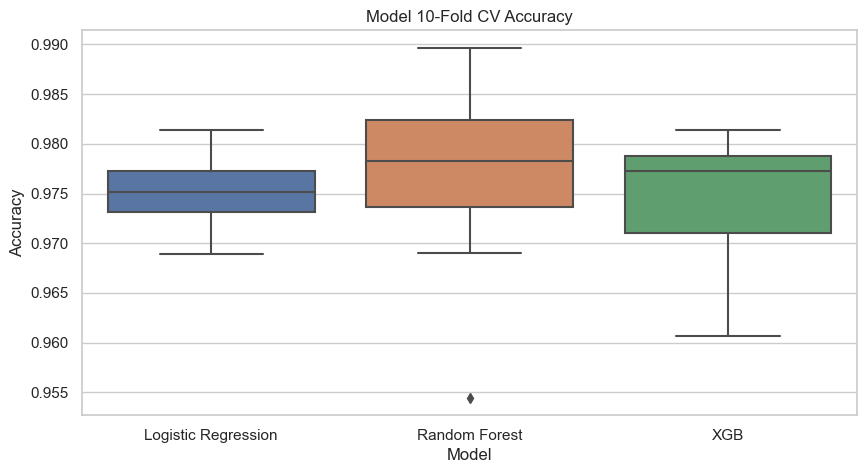

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.boxplot(data = pd.DataFrame(model_cv_scores))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model 10-Fold CV Accuracy")
plt.show()

It seems that the `RandomForestClassifier` is the most promising model to tune.

## Model Tuning

In [20]:
full_pipeline = Pipeline([
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('rf_model', RandomForestClassifier(random_state=93))
])

In [21]:
cv_accuracy = {'Untuned': model_cv_scores["Random Forest"]}

### Tuning on Subset

Take a smaller subset of the data for initial tuning:

In [22]:
spam_indices = np.where(y_train == 1)[0]
ham_indices = np.where(y_train == 0)[0]

subset_size = 600
subset_size_spam = int(subset_size * len(spam_indices) / len(y_train))
subset_size_ham = subset_size - subset_size_spam

spam_indices_subset = np.random.choice(spam_indices, subset_size_spam, replace=False)
ham_indices_subset = np.random.choice(ham_indices, subset_size_ham, replace=False)

subset_indices = np.concatenate((spam_indices_subset, ham_indices_subset))
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]

In [23]:
param_dist = {
    'preprocessing_pipeline__word_counter__remove_stop_words': [True, False],
    'preprocessing_pipeline__word_counter__stemming': [True, False],
    'preprocessing_pipeline__vectorizer__vocabulary_size': randint(100, 2000),
    'preprocessing_pipeline__vectorizer__word_count_threshold': randint(5, 20),
    'rf_model__criterion': ["gini", "entropy"],
    'rf_model__max_features': ["sqrt", "log2"],
    'rf_model__n_estimators': randint(10, 400),
    'rf_model__max_depth': [None, 10, 20, 30],
}

**Warning:** The following cell takes a while to run.

In [24]:
random_search = RandomizedSearchCV(
    estimator = full_pipeline,
    param_distributions = param_dist,
    n_iter = 200,
    cv = 3,
    scoring = 'accuracy',
    random_state = 93,
    n_jobs = -1,
)

random_search.fit(X_train_subset, y_train_subset)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing_pipeline',
                                              Pipeline(steps=[('word_counter',
                                                               EmailToWordCounterTransformer()),
                                                              ('vectorizer',
                                                               WordCounterToVectorTransformer())])),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=93))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'preprocessing_pipeline__vectorizer__vocabulary_size': <scipy....
                                        'preprocessing_pipeline__word_counter__remove_stop_words': [True,
                                                                                                    False],
                                       

In [25]:
random_search.best_params_

{'preprocessing_pipeline__vectorizer__vocabulary_size': 1673,
 'preprocessing_pipeline__vectorizer__word_count_threshold': 17,
 'preprocessing_pipeline__word_counter__remove_stop_words': False,
 'preprocessing_pipeline__word_counter__stemming': False,
 'rf_model__criterion': 'entropy',
 'rf_model__max_depth': None,
 'rf_model__max_features': 'log2',
 'rf_model__n_estimators': 262}

In [26]:
random_search_model = clone(random_search.best_estimator_)

In [27]:
cv_accuracy['Subset Tuning'] = cross_val_score(random_search_model, X_train, y_train,
                                               cv=10, scoring='accuracy', n_jobs=-1)

In [28]:
print("Accuracy:", cv_accuracy['Subset Tuning'].mean())

Accuracy: 0.9735357527847646


### Fine-Tuning on Full Training Set

In [29]:
param_grid = {
    'preprocessing_pipeline__vectorizer__vocabulary_size': [1250, 1400, 1500, 1600, 1750],
    'preprocessing_pipeline__vectorizer__word_count_threshold': [6, 7, 8, 9, 10],
    'preprocessing_pipeline__word_counter__remove_stop_words': [True],
    'preprocessing_pipeline__word_counter__stemming': [True, False],
    'rf_model__criterion': ['entropy'],
    'rf_model__max_depth': [None],
    'rf_model__max_features': ['auto', 'log2'],
    'rf_model__n_estimators': [100, 130, 160]
}

In [30]:
grid_search = GridSearchCV(
    estimator = full_pipeline,
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    n_jobs = -1,
)

grid_search.fit(X_train_subset, y_train_subset)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing_pipeline',
                                        Pipeline(steps=[('word_counter',
                                                         EmailToWordCounterTransformer()),
                                                        ('vectorizer',
                                                         WordCounterToVectorTransformer())])),
                                       ('rf_model',
                                        RandomForestClassifier(random_state=93))]),
             n_jobs=-1,
             param_grid={'preprocessing_pipeline__vectorizer__vocabulary_size': [1250,
                                                                                 1400,
                                                                                 1500,
                                                                                 1600,
                                                                             

In [31]:
grid_search.best_params_

{'preprocessing_pipeline__vectorizer__vocabulary_size': 1500,
 'preprocessing_pipeline__vectorizer__word_count_threshold': 8,
 'preprocessing_pipeline__word_counter__remove_stop_words': True,
 'preprocessing_pipeline__word_counter__stemming': False,
 'rf_model__criterion': 'entropy',
 'rf_model__max_depth': None,
 'rf_model__max_features': 'log2',
 'rf_model__n_estimators': 100}

Some of the tuned hyperparameters were on the edge so we do a final grid search with an expanded search area for only boundary values.

In [32]:
param_grid = {
    'preprocessing_pipeline__vectorizer__vocabulary_size': [800, 900, 1000, 1100, 1200, 1300],
    'preprocessing_pipeline__vectorizer__word_count_threshold': [10, 11, 12, 13],
    'preprocessing_pipeline__word_counter__remove_stop_words': [True],
    'preprocessing_pipeline__word_counter__stemming': [True, False],
    'rf_model__criterion': ['entropy'],
    'rf_model__max_depth': [None],
    'rf_model__max_features': ['log2'],
    'rf_model__n_estimators': [160, 180, 200]
}

In [33]:
grid_search = GridSearchCV(
    estimator = full_pipeline,
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    n_jobs = -1,
)

grid_search.fit(X_train_subset, y_train_subset)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing_pipeline',
                                        Pipeline(steps=[('word_counter',
                                                         EmailToWordCounterTransformer()),
                                                        ('vectorizer',
                                                         WordCounterToVectorTransformer())])),
                                       ('rf_model',
                                        RandomForestClassifier(random_state=93))]),
             n_jobs=-1,
             param_grid={'preprocessing_pipeline__vectorizer__vocabulary_size': [800,
                                                                                 900,
                                                                                 1000,
                                                                                 1100,
                                                                               

In [34]:
grid_search.best_params_

{'preprocessing_pipeline__vectorizer__vocabulary_size': 1000,
 'preprocessing_pipeline__vectorizer__word_count_threshold': 13,
 'preprocessing_pipeline__word_counter__remove_stop_words': True,
 'preprocessing_pipeline__word_counter__stemming': False,
 'rf_model__criterion': 'entropy',
 'rf_model__max_depth': None,
 'rf_model__max_features': 'log2',
 'rf_model__n_estimators': 180}

There are some hyperparameters that are tuned to edge cases again, but these were the edges in the opposite direction for the previous grid search so we are happy we have found relatively optimal hyperparameters.

In [35]:
best_estimator = grid_search.best_estimator_

### Analysis of Final Model Performance

In [36]:
cv_accuracy['Best Estimator'] = cross_val_score(best_estimator, X_train, y_train,
                                                cv=10, scoring='accuracy', n_jobs=-1)

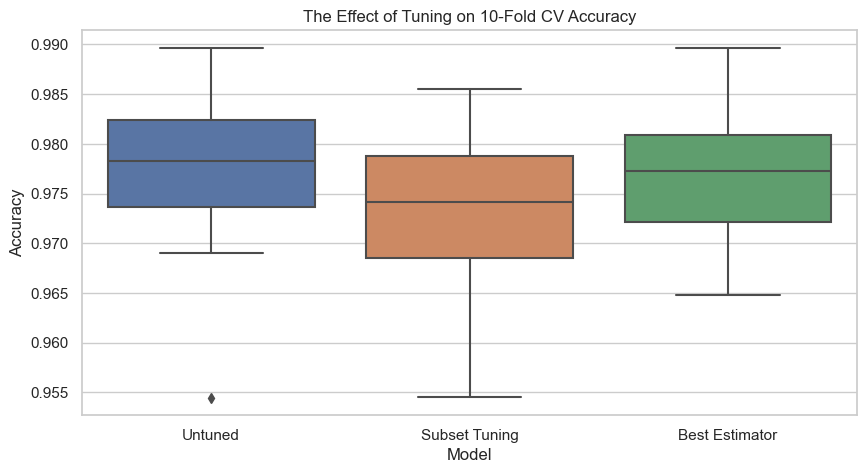

In [37]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.boxplot(data = pd.DataFrame(cv_accuracy))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("The Effect of Tuning on 10-Fold CV Accuracy")
plt.show()

Interestingly, whilst the best estimator did have the highest mean accuracy and does look like the most promising model, it also has a the smallest accuracy in one of its folds (_except for an outlier in the Untuned model_) and the untuned model has the highest.

## Test Set Predictions

In [38]:
y_pred = best_estimator.predict(X_test)

### $F_1$ Score, Precision and Recall

In [39]:
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

F1 Score: 91.35%
Precision: 92.15%
Recall: 90.57%


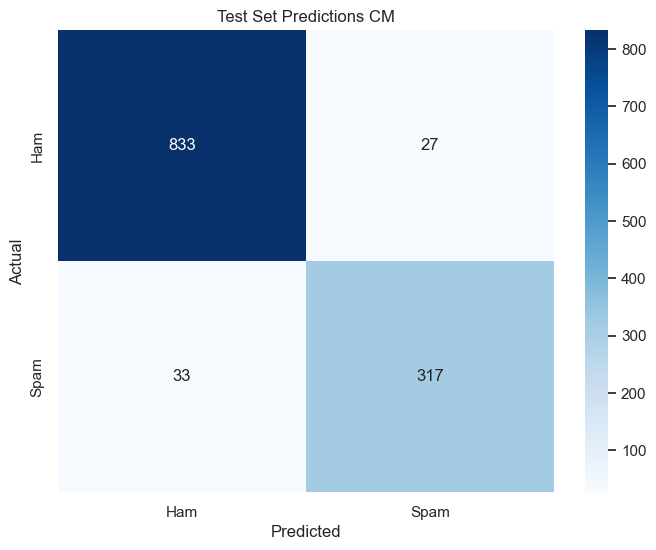

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Predictions CM")
plt.show()